## **Import the libraries** ##

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

%matplotlib inline

## **Create the files** ##
Dont need to run this part again

In [ ]:
#Create the dataframes
df_clients = pd.read_csv("../Data/Raw/df_final_experiment_clients.txt")
df_demo = pd.read_csv("../Data/Raw/df_final_demo.txt")
df_web1 = pd.read_csv("../Data/Raw/df_final_web_data_pt_1.txt")
df_web2 = pd.read_csv("../Data/Raw/df_final_web_data_pt_2.txt")
df_clients.head()

In [ ]:
#Concat data_web
df_web=pd.concat([df_web1,df_web2], axis=0)
df_web=df_web.reset_index(drop=True)
df_web

In [ ]:
#Merge demo with clients
df_demo=pd.merge(df_demo,df_clients, on="client_id", how="left")



In [ ]:
#I create demo_control
conditioncontrol=df_demo["Variation"]=="Control"
df_demo_control=df_demo[conditioncontrol]
df_demo_control

In [ ]:
#I create demo_test
conditiontest=df_demo["Variation"]=="Test"
df_demo_test=df_demo[conditiontest]
df_demo_test

In [ ]:
#I add information about the clientes to data_web
df_web=pd.merge(df_web,df_clients, on="client_id", how="left")
df_web

In [ ]:
#Create web_test
conditiontest=df_web["Variation"]=="Test"
df_web_test=df_web[conditiontest]
df_web_test

In [ ]:
#Create web_control
conditioncontrol=df_web["Variation"]=="Control"
df_web_control=df_web[conditioncontrol]
df_web_control

In [ ]:
#FINAL RESULT 4 FILES:
#df_web_control
#df_web_test
#df_demo_control
#df_demo_test
df_web_test.to_csv("../Data/Raw/df_final_web_data_test.txt")

## **Cleaning and columns aggregation** ##

In [6]:
#Clean web_data_test 1148 duplicated values
df_web_test = pd.read_csv("../Data/Raw/df_final_web_data_test.txt")
df_web_test=df_web_test.reset_index(drop=True)
df_web_test.duplicated().sum()
df_web_test.drop_duplicates(inplace=True)
df_web_test.duplicated().sum()

0

In [8]:
#Split date and time
df_web_test["date"]=df_web_test["date_time"].str.split(" ", expand=True)[0]
df_web_test["time"]=df_web_test["date_time"].str.split(" ", expand=True)[1]
df_web_test["hour"]=df_web_test["time"].str.split(":",expand=True)[0]
df_web_test["hour"]=df_web_test["hour"].astype(int)
df_web_test.head()

,Unnamed: 0,client_id,visitor_id,visit_id,process_step,date_time,Variation,date,time,hour
0,0,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:27:07,Test,2017-04-17,15:27:07,15
1,1,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:26:51,Test,2017-04-17,15:26:51,15
2,2,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:19:22,Test,2017-04-17,15:19:22,15
3,3,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:19:13,Test,2017-04-17,15:19:13,15
4,4,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:18:04,Test,2017-04-17,15:18:04,15


In [10]:
#Change the dtypes of the column time %H,%M,%S format
df_web_test['time'] = (pd.to_datetime(df_web_test['time'], format='%H:%M:%S'))
df_web_test

,Unnamed: 0,client_id,visitor_id,visit_id,process_step,date_time,Variation,date,time,hour
0,0,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:27:07,Test,2017-04-17,1900-01-01 15:27:07,15
1,1,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:26:51,Test,2017-04-17,1900-01-01 15:26:51,15
2,2,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:19:22,Test,2017-04-17,1900-01-01 15:19:22,15
3,3,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:19:13,Test,2017-04-17,1900-01-01 15:19:13,15
4,4,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:18:04,Test,2017-04-17,1900-01-01 15:18:04,15
...,...,...,...,...,...,...,...,...,...,...
177842,637483,1574008,117364417_77840596075,528720790_71583064618_169151,confirm,2017-05-06 23:51:05,Test,2017-05-06,1900-01-01 23:51:05,23
177843,637484,1574008,117364417_77840596075,528720790_71583064618_169151,step_3,2017-05-06 23:50:40,Test,2017-05-06,1900-01-01 23:50:40,23
177844,637485,1574008,117364417_77840596075,528720790_71583064618_169151,step_2,2017-05-06 23:43:47,Test,2017-05-06,1900-01-01 23:43:47,23
177845,637486,1574008,117364417_77840596075,528720790_71583064618_169151,step_1,2017-05-06 23:43:34,Test,2017-05-06,1900-01-01 23:43:34,23


In [12]:
#Change the values of process_step
df_web_test["process_step"]=df_web_test["process_step"].map({"start":0,"step_1":1,"step_2":2,"step_3":3,"confirm":4})
df_web_test["process_step"].unique()

array([3, 2, 1, 0, 4], dtype=int64)

In [14]:
#Create two new columns in order to have the step_jump and one column "control" to filter when the data is not from the same visit_id.
df_web_test=df_web_test.sort_values(["visit_id","date", "time", "process_step"])
df_web_test["step_jump"]=df_web_test["process_step"].astype(str).shift(+1)+"-"+df_web_test["process_step"].astype(str)
#Create column control which help me to determine, later, is the steps follows a orded sense.
df_web_test["control"]=(df_web_test["process_step"]-df_web_test["process_step"].shift(+1)).abs()
df_web_test["dif_time"]=(df_web_test["time"])-(df_web_test["time"].shift(+1))
df_web_test

,Unnamed: 0,client_id,visitor_id,visit_id,process_step,date_time,Variation,date,time,hour,step_jump,control,dif_time
61531,108614,3561384,451664975_1722933822,100012776_37918976071_457913,4,2017-04-26 13:22:17,Test,2017-04-26,1900-01-01 13:22:17,13,NaN,NaN,NaT
61530,108613,3561384,451664975_1722933822,100012776_37918976071_457913,4,2017-04-26 13:23:09,Test,2017-04-26,1900-01-01 13:23:09,13,4-4,0.0,0 days 00:00:52
137143,240562,7338123,612065484_94198474375,100019538_17884295066_43909,0,2017-04-09 16:20:56,Test,2017-04-09,1900-01-01 16:20:56,16,4-0,4.0,0 days 02:57:47
137142,240561,7338123,612065484_94198474375,100019538_17884295066_43909,1,2017-04-09 16:21:12,Test,2017-04-09,1900-01-01 16:21:12,16,0-1,1.0,0 days 00:00:16
137141,240560,7338123,612065484_94198474375,100019538_17884295066_43909,2,2017-04-09 16:21:21,Test,2017-04-09,1900-01-01 16:21:21,16,1-2,1.0,0 days 00:00:09
...,...,...,...,...,...,...,...,...,...,...,...,...,...
55158,97222,6627522,730634087_44272418812,999988789_76411676596_272843,0,2017-04-21 23:49:11,Test,2017-04-21,1900-01-01 23:49:11,23,4-0,4.0,0 days 12:28:04
55157,97221,6627522,730634087_44272418812,999988789_76411676596_272843,1,2017-04-21 23:49:22,Test,2017-04-21,1900-01-01 23:49:22,23,0-1,1.0,0 days 00:00:11
55156,97220,6627522,730634087_44272418812,999988789_76411676596_272843,2,2017-04-21 23:50:16,Test,2017-04-21,1900-01-01 23:50:16,23,1-2,1.0,0 days 00:00:54
55155,97219,6627522,730634087_44272418812,999988789_76411676596_272843,1,2017-04-21 23:51:00,Test,2017-04-21,1900-01-01 23:51:00,23,2-1,1.0,0 days 00:00:44


In [16]:
#Create a column for the total of segs spend between steps
df_web_test=df_web_test.dropna(subset=["control"])
df_web_test["dif_time"] = (df_web_test['dif_time'].astype(str))
df_web_test["dif_time"]=(df_web_test["dif_time"].str.split(" ")).str[-1]
df_web_test["dif_hour"]=((df_web_test["dif_time"].str.split(":")).str[0])
df_web_test["dif_hour"]=df_web_test["dif_hour"].astype(int)
df_web_test["dif_min"]=((df_web_test["dif_time"].str.split(":")).str[1]).astype(int)
df_web_test["dif_seg"]=((df_web_test["dif_time"].str.split(":")).str[2]).astype(int)
df_web_test["total_seg"]=df_web_test["dif_hour"]*3600 + df_web_test["dif_min"]*60 + df_web_test["dif_seg"]
df_web_test

C:\Users\Usuario\AppData\Local\Temp\ipykernel_17240\3333997201.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_web_test["dif_time"] = (df_web_test['dif_time'].astype(str))
C:\Users\Usuario\AppData\Local\Temp\ipykernel_17240\3333997201.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_web_test["dif_time"]=(df_web_test["dif_time"].str.split(" ")).str[-1]
C:\Users\Usuario\AppData\Local\Temp\ipykernel_17240\3333997201.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fr

,Unnamed: 0,client_id,visitor_id,visit_id,process_step,date_time,Variation,date,time,hour,step_jump,control,dif_time,dif_hour,dif_min,dif_seg,total_seg
61530,108613,3561384,451664975_1722933822,100012776_37918976071_457913,4,2017-04-26 13:23:09,Test,2017-04-26,1900-01-01 13:23:09,13,4-4,0.0,00:00:52,0,0,52,52
137143,240562,7338123,612065484_94198474375,100019538_17884295066_43909,0,2017-04-09 16:20:56,Test,2017-04-09,1900-01-01 16:20:56,16,4-0,4.0,02:57:47,2,57,47,10667
137142,240561,7338123,612065484_94198474375,100019538_17884295066_43909,1,2017-04-09 16:21:12,Test,2017-04-09,1900-01-01 16:21:12,16,0-1,1.0,00:00:16,0,0,16,16
137141,240560,7338123,612065484_94198474375,100019538_17884295066_43909,2,2017-04-09 16:21:21,Test,2017-04-09,1900-01-01 16:21:21,16,1-2,1.0,00:00:09,0,0,9,9
137140,240559,7338123,612065484_94198474375,100019538_17884295066_43909,1,2017-04-09 16:21:35,Test,2017-04-09,1900-01-01 16:21:35,16,2-1,1.0,00:00:14,0,0,14,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55158,97222,6627522,730634087_44272418812,999988789_76411676596_272843,0,2017-04-21 23:49:11,Test,2017-04-21,1900-01-01 23:49:11,23,4-0,4.0,12:28:04,12,28,4,44884
55157,97221,6627522,730634087_44272418812,999988789_76411676596_272843,1,2017-04-21 23:49:22,Test,2017-04-21,1900-01-01 23:49:22,23,0-1,1.0,00:00:11,0,0,11,11
55156,97220,6627522,730634087_44272418812,999988789_76411676596_272843,2,2017-04-21 23:50:16,Test,2017-04-21,1900-01-01 23:50:16,23,1-2,1.0,00:00:54,0,0,54,54
55155,97219,6627522,730634087_44272418812,999988789_76411676596_272843,1,2017-04-21 23:51:00,Test,2017-04-21,1900-01-01 23:51:00,23,2-1,1.0,00:00:44,0,0,44,44


In [18]:
#Function for the keep_control column. It is only going to be used in terms of TIME BETWEEN STEPS
def row_count(df):
    df['next_visit'] = df['visit_id'].shift(+1) 
    df['keep_contol'] = df.apply(lambda row: "YES" if row['visit_id'] == row['next_visit'] else "NO", axis=1)
    df.drop(columns=['next_visit'], inplace=True)
    return df

In [20]:
#Add the column keep_control to my DataFrame
df_web_test=row_count(df_web_test)
df_web_test

#FINAL DATA FRAME TO USE: df_web_test

C:\Users\Usuario\AppData\Local\Temp\ipykernel_17240\3722212704.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['next_visit'] = df['visit_id'].shift(+1)
C:\Users\Usuario\AppData\Local\Temp\ipykernel_17240\3722212704.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['keep_contol'] = df.apply(lambda row: "YES" if row['visit_id'] == row['next_visit'] else "NO", axis=1)
C:\Users\Usuario\AppData\Local\Temp\ipykernel_17240\3722212704.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy 

,Unnamed: 0,client_id,visitor_id,visit_id,process_step,date_time,Variation,date,time,hour,step_jump,control,dif_time,dif_hour,dif_min,dif_seg,total_seg,keep_contol
61530,108613,3561384,451664975_1722933822,100012776_37918976071_457913,4,2017-04-26 13:23:09,Test,2017-04-26,1900-01-01 13:23:09,13,4-4,0.0,00:00:52,0,0,52,52,NO
137143,240562,7338123,612065484_94198474375,100019538_17884295066_43909,0,2017-04-09 16:20:56,Test,2017-04-09,1900-01-01 16:20:56,16,4-0,4.0,02:57:47,2,57,47,10667,NO
137142,240561,7338123,612065484_94198474375,100019538_17884295066_43909,1,2017-04-09 16:21:12,Test,2017-04-09,1900-01-01 16:21:12,16,0-1,1.0,00:00:16,0,0,16,16,YES
137141,240560,7338123,612065484_94198474375,100019538_17884295066_43909,2,2017-04-09 16:21:21,Test,2017-04-09,1900-01-01 16:21:21,16,1-2,1.0,00:00:09,0,0,9,9,YES
137140,240559,7338123,612065484_94198474375,100019538_17884295066_43909,1,2017-04-09 16:21:35,Test,2017-04-09,1900-01-01 16:21:35,16,2-1,1.0,00:00:14,0,0,14,14,YES
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55158,97222,6627522,730634087_44272418812,999988789_76411676596_272843,0,2017-04-21 23:49:11,Test,2017-04-21,1900-01-01 23:49:11,23,4-0,4.0,12:28:04,12,28,4,44884,NO
55157,97221,6627522,730634087_44272418812,999988789_76411676596_272843,1,2017-04-21 23:49:22,Test,2017-04-21,1900-01-01 23:49:22,23,0-1,1.0,00:00:11,0,0,11,11,YES
55156,97220,6627522,730634087_44272418812,999988789_76411676596_272843,2,2017-04-21 23:50:16,Test,2017-04-21,1900-01-01 23:50:16,23,1-2,1.0,00:00:54,0,0,54,54,YES
55155,97219,6627522,730634087_44272418812,999988789_76411676596_272843,1,2017-04-21 23:51:00,Test,2017-04-21,1900-01-01 23:51:00,23,2-1,1.0,00:00:44,0,0,44,44,YES


## **Analysis** ##

## **Device** ##

In [24]:
#Create a new date_frame to see the use of device
df_web_test_device=df_web_test[["client_id","visitor_id"]]
df_web_test_device=df_web_test_device.drop_duplicates()
df_web_test_device=pd.DataFrame(df_web_test_device.groupby("client_id")["visitor_id"].count())
df_web_test_device=df_web_test_device.rename(columns={"visitor_id":"num_devices"})
df_web_test_device=df_web_test_device.reset_index()
df_web_test_device

,client_id,num_devices
0,555,1
1,647,1
2,934,1
3,1336,1
4,1346,1
...,...,...
26963,9999150,1
26964,9999400,1
26965,9999626,1
26966,9999729,3


In [26]:
device_stat=df_web_test_device["num_devices"].describe()
device_mode=df_web_test_device["num_devices"].mode()[0]

print(f"The stadictical for the number of device per client is {device_stat}")
print(f"The mode for the number of device pero cliente is {device_mode}")

The stadictical for the number of device per client is count    26968.000000
mean         1.113023
std          0.407203
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         11.000000
Name: num_devices, dtype: float64
The mode for the number of device pero cliente is 1


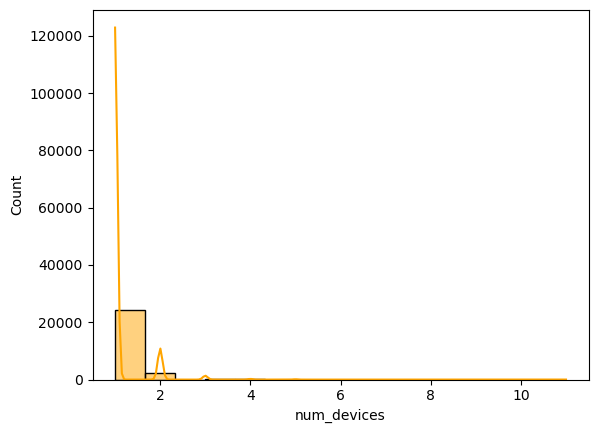

In [28]:
sns.histplot(df_web_test_device['num_devices'], kde=True, bins=15, color="orange")
plt.show()

**Analysis**: from all the almost 27.000 clients, almost 75% of the customer only use 1 device to get into our portal.There is some clients who use more than 4 devices that we can consider outliners.

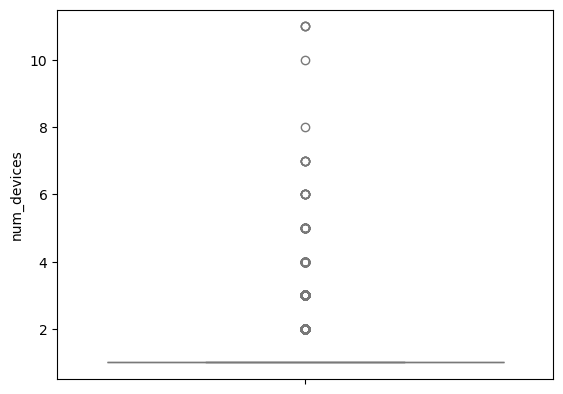

In [31]:
sns.boxplot(df_web_test_device['num_devices'], color="lightblue")
plt.show()

## **Connection times** ##

In [34]:
#Create a new date_frame to see how many interaction has been made for each client
df_web_test_visit=df_web_test[["client_id","visit_id"]]
df_web_test_visit=df_web_test_visit.drop_duplicates()
df_web_test_visit=pd.DataFrame(df_web_test_visit.groupby("client_id")["visit_id"].count())
df_web_test_visit=df_web_test_visit.rename(columns={"visit_id":"num_visits"})
df_web_test_visit=df_web_test_visit.reset_index()
df_web_test_visit

,client_id,num_visits
0,555,1
1,647,1
2,934,1
3,1336,2
4,1346,1
...,...,...
26963,9999150,1
26964,9999400,1
26965,9999626,1
26966,9999729,3


In [36]:
visit_stat=df_web_test_visit["num_visits"].describe()
visit_mode=df_web_test_visit["num_visits"].mode()[0]

print(f"The stadictical for the number of device per client is {visit_stat}")
print(f"The mode for the number of device pero cliente is {visit_mode}")

The stadictical for the number of device per client is count    26968.000000
mean         1.379561
std          0.811504
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         14.000000
Name: num_visits, dtype: float64
The mode for the number of device pero cliente is 1


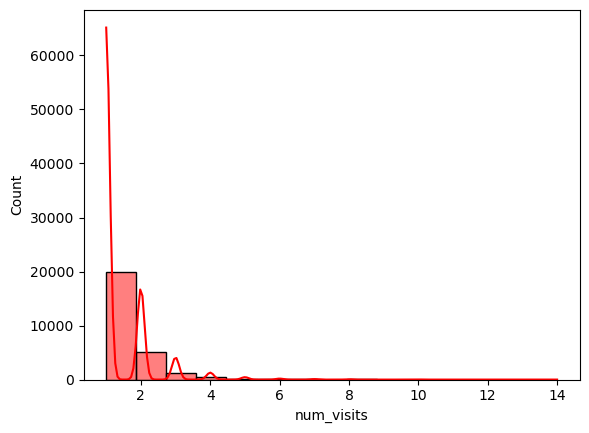

In [38]:
sns.histplot(df_web_test_visit['num_visits'], kde=True, bins=15, color="red")
plt.show()

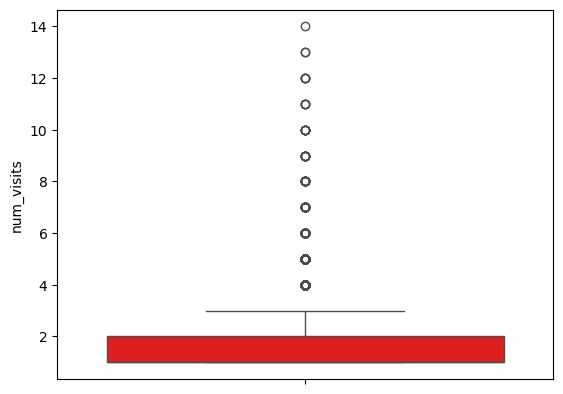

In [40]:
sns.boxplot(df_web_test_visit['num_visits'], color="red")
plt.show()

**Analysis**: The test clients have only interact one time with the new web. As we can see the mean of interactions is 1.37 and only 25% of the total clients have interact with the web, at least, 2 times. We also see some outliner which has interact with the web more than 4 times.

## **STEPS**

In [44]:
df_web_test["process_step"].describe()

count    177846.000000
mean          1.581773
std           1.427361
min           0.000000
25%           0.000000
50%           1.000000
75%           3.000000
max           4.000000
Name: process_step, dtype: float64

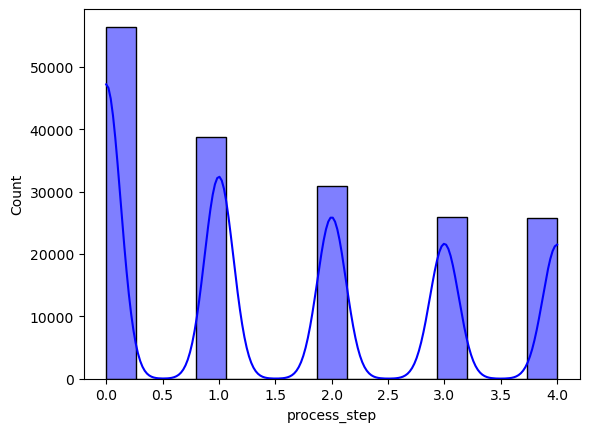

In [46]:
sns.histplot(df_web_test['process_step'], kde=True, bins=15, color="blue")
plt.show()

**Analysis**: The web is a little bit confusing. The clients, as average, do not reach the second step and they get stack in the step 1. Less than 25% of the clients reach the final step. But all the clients which reach the setp 3 get to finish the whole process. So the more confusing part are in order to get to step 1 as we can see more difference in the histoplot. The difficulty decrese as the steps go ahead.

## **Hour**

In [50]:
df_web_test_hour=df_web_test.sort_values("hour", ascending=True)
df_web_test_hour=df_web_test_hour[["visit_id","hour"]]
df_web_test_hour=df_web_test_hour.drop_duplicates()
df_web_test_hour

,visit_id,hour
47280,870190074_29671901808_765379,0
30959,817443435_61080697825_176022,0
60592,906410128_43337083823_596149,0
85955,192505390_22935057296_646170,0
169126,956711551_37747457931_497511,0
...,...,...
70768,226224025_82504978730_541107,23
48885,984151385_74482790970_727846,23
39950,349463764_81006653638_435721,23
92387,941086657_21366006832_198684,23


In [52]:
df_web_test_hour["hour"].describe()

count    40217.000000
mean        13.849094
std          4.936782
min          0.000000
25%         11.000000
50%         13.000000
75%         18.000000
max         23.000000
Name: hour, dtype: float64

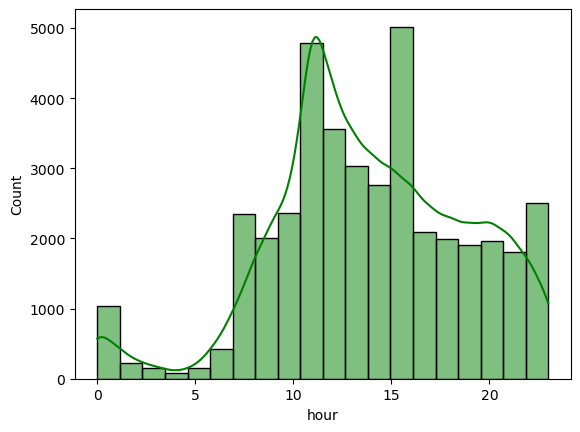

In [54]:
sns.histplot(df_web_test_hour['hour'], kde=True, bins=20, color="green")
plt.show()

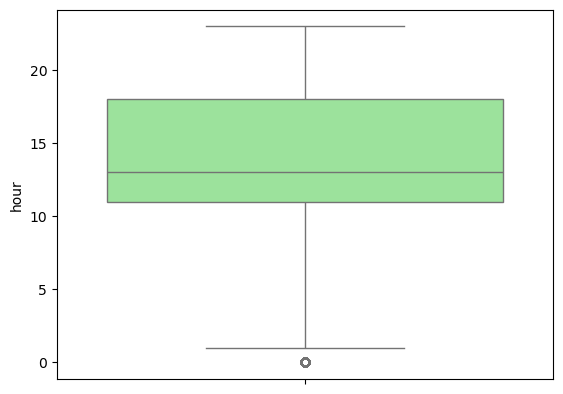

In [56]:
sns.boxplot(df_web_test_hour['hour'], color="lightgreen")
plt.show()

**Analysis**: More of the interactis has been made between 10 am to 15 pm. There is just some outlines which access to the 12 am 

## **Time between steps** ##

In [60]:
#Filter what we want: control condition 1, steps forward 0-1;1-2;2-3;3-4. keep_control=YES
condition_control=df_web_test["control"]==1
df_web_test_dif_time=df_web_test[condition_control]
condition_step=(df_web_test["step_jump"]=="0-1") | (df_web_test["step_jump"]=="1-2") | (df_web_test["step_jump"]=="2-3") | (df_web_test["step_jump"]=="3-4")
df_web_test_dif_time=df_web_test_dif_time[condition_step]
condition_keep=df_web_test_dif_time["keep_contol"]=="YES"
df_web_test_dif_time=df_web_test_dif_time[condition_keep]
df_web_test_dif_time
df_web_test_dif_time

C:\Users\Usuario\AppData\Local\Temp\ipykernel_17240\1848279334.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_web_test_dif_time=df_web_test_dif_time[condition_step]


,Unnamed: 0,client_id,visitor_id,visit_id,process_step,date_time,Variation,date,time,hour,step_jump,control,dif_time,dif_hour,dif_min,dif_seg,total_seg,keep_contol
137142,240561,7338123,612065484_94198474375,100019538_17884295066_43909,1,2017-04-09 16:21:12,Test,2017-04-09,1900-01-01 16:21:12,16,0-1,1.0,00:00:16,0,0,16,16,YES
137141,240560,7338123,612065484_94198474375,100019538_17884295066_43909,2,2017-04-09 16:21:21,Test,2017-04-09,1900-01-01 16:21:21,16,1-2,1.0,00:00:09,0,0,9,9,YES
137136,240555,7338123,612065484_94198474375,100019538_17884295066_43909,1,2017-04-09 16:22:04,Test,2017-04-09,1900-01-01 16:22:04,16,0-1,1.0,00:00:05,0,0,5,5,YES
137135,240554,7338123,612065484_94198474375,100019538_17884295066_43909,2,2017-04-09 16:22:08,Test,2017-04-09,1900-01-01 16:22:08,16,1-2,1.0,00:00:04,0,0,4,4,YES
137134,240553,7338123,612065484_94198474375,100019538_17884295066_43909,3,2017-04-09 16:24:01,Test,2017-04-09,1900-01-01 16:24:01,16,2-3,1.0,00:01:53,0,1,53,113,YES
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46510,81692,829911,648229874_89449279372,999984454_18731538378_781808,2,2017-03-29 11:19:32,Test,2017-03-29,1900-01-01 11:19:32,11,1-2,1.0,00:00:41,0,0,41,41,YES
46509,81691,829911,648229874_89449279372,999984454_18731538378_781808,3,2017-03-29 11:20:23,Test,2017-03-29,1900-01-01 11:20:23,11,2-3,1.0,00:00:51,0,0,51,51,YES
46508,81690,829911,648229874_89449279372,999984454_18731538378_781808,4,2017-03-29 11:21:07,Test,2017-03-29,1900-01-01 11:21:07,11,3-4,1.0,00:00:44,0,0,44,44,YES
55157,97221,6627522,730634087_44272418812,999988789_76411676596_272843,1,2017-04-21 23:49:22,Test,2017-04-21,1900-01-01 23:49:22,23,0-1,1.0,00:00:11,0,0,11,11,YES


In [62]:
df_web_test_dif_time["total_seg"].describe()

count    103496.000000
mean         58.681205
std         102.058354
min           0.000000
25%          12.000000
50%          30.000000
75%          67.000000
max        3636.000000
Name: total_seg, dtype: float64

In [64]:
time_stat=df_web_test_dif_time.groupby("step_jump")["total_seg"].agg(["count","median","std"])
time_stat

,count,median,std
step_jump,,,
0-1,33372,10.0,86.146898
1-2,27535,24.0,57.903721
2-3,24218,66.0,84.526467
3-4,18371,52.0,159.805556


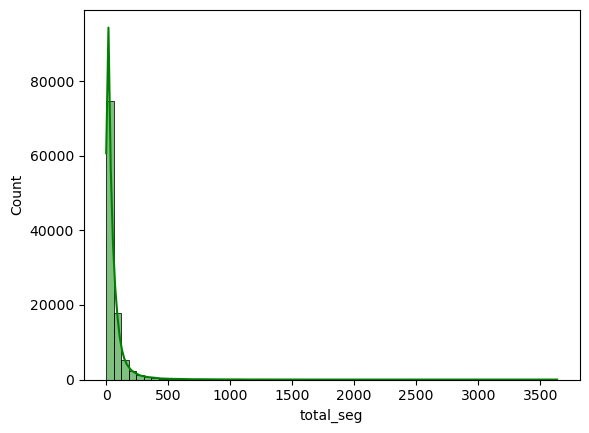

In [66]:
sns.histplot(df_web_test_dif_time['total_seg'], kde=True, bins=60, color="green")
plt.show()

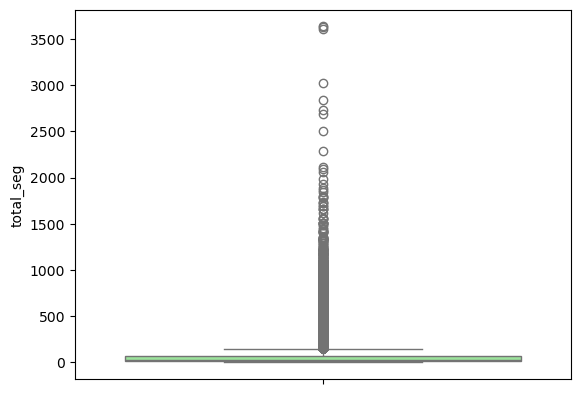

In [68]:
sns.boxplot(df_web_test_dif_time['total_seg'], color="lightgreen")
plt.show()

## **Completion ratio** ##

In [ ]:
#Completion ratio: number of visit in steo 0 / number of visit in step 4
